# TD Lambda + Tile Coding for Heartbeat prediction

Import libraries: numpy, tile_coding

tile_coding is our own library to be used as a linear approximation function.

In [4]:
import numpy as np
from tile_coding import *

## 1. TD Lambda with tile coding for nexting

* What we need more for this part

1.We need to reconsider the reward function.


2.Hyperparameters?

In [6]:
class Nexting:
    
    def __init__(self, reward_batch=1, exp_rate=0.1, lmbda=0.4, debug=True):
        self.actions = [-1, 0, 1]  # lower, 0 and upper beat
        self.state = (0,0)  # current heartbeat, predicted amount of change
        self.exp_rate = exp_rate
        self.end = False
        self.lmbda = lmbda
        self.rate_truncate = 1e-3
        self.reward_batch = reward_batch
        self.avg_pos_error = 0
        self.debug = debug
        self.step_num = 0
        
    def reset(self):
        pos = np.random.uniform(-0.3, 0.4) #?min max
        self.end = False
        self.state = (pos, 0)
        self.step_num = 0
        
    def takeAction(self, action):
        pos, gap = self.state
        
        #gap_new = gap + 0.001*action - 0.0025*np.cos(3*pos) #?
        gap_new = gap + 0.001*action
        gap_new = min(max(gap_new, GAP_BOUND[0]), GAP_BOUND[1])
        
        pos_new = pos + gap_new
        pos_new = min(max(pos_new, POSITION_BOUND[0][0]), POSITION_BOUND[0][1]) # need to change
        
        if pos_new == POSITION_BOUND[0][0]: #?
            #reach leftmost, set gap to 0
            gap_new = 0.0005 # non zero
            
        elif pos_new == POSITION_BOUND[0][1]:
            gap_new = -0.0005
             
        self.state = (pos_new, gap_new)
        
        return self.state ###
    
    def chooseAction(self, valueFunc):
         # choose an action based on the current state, 
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                value = valueFunc.value(self.state, a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v==max(values.values())])
        
    def giveReward(self): # ***
        
        self.step_num += 1
        pos, _ = self.state
        true_pos = data[self.step_num]
        r_value = -1
        self.avg_pos_error = (self.avg_pos_error + (pos - true_pos))/2
        
        if self.step_num >= len(data):
            self.step_num = len(data) - 1
        
        print(self.avg_pos_error)
        if self.avg_pos_error <= 0.05 and self.avg_pos_error >= -0.05:
            r_value = 0
        else:
            r_value = -1
                        
        if self.step_num == len(data) - 1:
            self.end = True
        
        return r_value
    
    def gt2tn(self, valueFunc, action, end):
        # only the last reward is non-zero
        reward = self.reward
        res = reward + valueFunc.value(self.state, action)
        
        return res
        
    def play(self, valueFunction, rounds=1):
        states_per_rounds = []
        
        for rnd in range(rounds):
            self.reset()
            action = self.chooseAction(valueFunction)
            
            actions = [action]
            states = [self.state]
            rewards = [-1]
            
            while not self.end:
                self.state = self.takeAction(action)  # next state
                self.reward = self.giveReward()
                
                states.append(self.state)
                action = self.chooseAction(valueFunction)
                
                if self.step_num % self.reward_batch == 0:
                    if self.debug:
                        print("total states {} end at {} reward {}".format(len(states), self.state, self.reward))
                        
                    T = len(states) - 1
                    
                    for t in range(T):
                        state = states[t]
                        gtlambda = 0
                        
                        for n in range(1, T-t):
                            gttn = self.gt2tn(valueFunction, action, t+n)
                            lambda_power = np.power(self.lmbda, n-1)
                            gtlambda += lambda_power*gttn
                            
                            if lambda_power < self.rate_truncate:
                                break
                                
                        gtlambda *= 1 - self.lmbda
                        
                        if lambda_power >= self.rate_truncate:
                            gtlambda += lambda_power*self.reward
                            
                        delta = gtlambda - valueFunction.value(self.state, action)
                        valueFunction.update(self.state, action, delta)
            
            states_per_rounds.append(states)
            
        return states_per_rounds

## 2. Loading the dataset

Please run the cell below if you don't have neurokit2 and mne as your python libraries. In case you have these two, you don't need to run the cell.

In [ ]:
!pip install neurokit2
!pip install mne

In [2]:
import pandas as pd
from sklearn.preprocessing import normalize
import neurokit2 as nk
import mne
import matplotlib.pyplot as plt

In [3]:
file = "data/r04.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# after normalization 
raw_data = normalize(raw_data,axis=1,norm="max")
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

# cleanup the data
for i in range(len(raw_data)):
    raw_data[i] = nk.ecg_clean(raw_data[i],method="neurokit")

# feature range
POSITION_BOUND = [] #? range of heartbeat
for i in range(len(raw_data)):
    POSITION_BOUND.append([min(raw_data[i]), max(raw_data[i])])

Extracting EDF parameters from /Users/Textory/Desktop/Fall2022/cmput655/data/r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


# 3. Settings to run TD lambda model for the dataset

* What we need more for this part

1.The experiment here is only for the first row of the dataset. We can use a simple loop for applying the model to our entire dataset.


2.We need to implement a progress bar of the model.


3.We need to change some hyper parameters.

In [7]:
data = raw_data[0][:10000]
GAP_BOUND = [-0.01, 0.01] #?
ACTIONS = [-1, 0, 1]
reward_batch = 300

feature_ranges = [POSITION_BOUND[0], GAP_BOUND]  # 2 features
number_tilings = 8
bins = [[100, 100] for _ in range(number_tilings)]
offsets = [[i, j] for i, j in zip(np.linspace(POSITION_BOUND[0][0], POSITION_BOUND[0][1], number_tilings), np.linspace(GAP_BOUND[0], GAP_BOUND[1], number_tilings))]

tilings = createTilings(feature_ranges, number_tilings, bins, offsets)

print("tiling shape: \n", tilings.shape)
print("offsets: \n", offsets)

valueFunc = qvalueFunction(tilings, ACTIONS, 0.3)

mc = Nexting(reward_batch=reward_batch)
predicted_states = mc.play(valueFunc, rounds=1)

tiling shape: 
 (8, 2, 99)
offsets: 
 [[-0.3326277028214003, -0.01], [-0.22827675655421997, -0.0071428571428571435], [-0.12392581028703961, -0.004285714285714286], [-0.01957486401985925, -0.0014285714285714284], [0.08477608224732108, 0.0014285714285714284], [0.18912702851450147, 0.004285714285714285], [0.2934779747816818, 0.0071428571428571435], [0.39782892104886214, 0.01]]
0.09548644887522705
0.14394895901589155
0.1693958501022894
0.18332912481306138
0.1909982915398718
0.19602710966488804
0.19972679611966085
0.20225179826530104
0.20417801249226306
0.20629172744037882
0.2079854242476783
0.20995434803598428
0.21254612229251457
0.21543489174127334
0.2179595563377012
0.22029288826599655
0.22202625651762434
0.222961324861163
0.22350340962945797
0.22385566741542884
0.2246168532393766
0.22558186048391105
0.22614481427164668
0.2265037736712229
0.22676241848090906
0.22647923182189464
0.2264384376782077
0.22653380886816177
0.22621007279052552
0.22618610549537477
0.2268185216777328
0.22828629303

-0.12350937542809755
-0.1134753470796217
-0.10337323446585765
-0.09372959146770365
-0.08480686468691596
-0.07673561316569161
-0.06958294336437593
-0.06338838744882812
-0.05718001555574036
-0.05047983464767804
-0.043053332423426835
-0.03528408319331469
-0.027861881216128398
-0.020630295044446585
-0.014011607256264186
-0.007221277279018595
-0.00037284768368570954
0.006971429546535557
0.015027272840095687
0.02340287350798952
0.032404154020989756
0.041686566749008155
0.05057983077181818
0.05924996812471428
0.06778098624074673
0.07621787820990492
0.0840872925094534
0.09115687138999323
0.09781242887072503
0.10474504501842027
0.11179544348616328
0.11937933579989521
0.1277029168591568
0.13637260564567438
0.145198753018695
0.15409533657458893
0.16302532392066899
0.1719726899926959
0.18092909003303637
0.18988952119765878
0.19885330887680458
0.20782443377547294
0.21680986857530044
0.22581608898788227
0.23484633280232609
0.24389906332917824
0.2529703566395598
0.26205725422280074
0.2711606018742156

0.32900438028798507
0.3269365593533017
0.3244217114885163
0.3222157058765531
0.3197081026495441
0.31709866422039445
0.314986441347822
0.3131651465681331
0.3110234981887302
0.3092463887639733
0.30816762837117667
0.3074463162486074
0.30640535877418795
0.3052015588541035
0.3034098302178501
0.30081530456575967
0.2978093851427623
0.29408760744541707
0.28949873565527895
0.2849681482966244
0.2809593649854636
0.27720447764434386
0.273068535710497
0.2687324030593171
0.2637843525459519
0.25851769015446113
0.2525802313918019
0.24579870732511855
0.23858930680187657
0.231162283240525
0.22362243114746508
0.21652081909419552
0.21013248308424884
0.20459610363591582
0.19898467472286413
0.19334034000489447
0.1876891536656999
0.18204646787353168
0.17641912827197895
0.1708077342843173
0.1657092639843443
0.16137021341016056
0.15691466093972156
0.15290780123906028
0.1486367157572918
0.1437484328561992
0.1380676292362174
0.1320051484897231
0.12626441941574557
0.12019549557657833
0.11447473235370455
0.1089431

-0.03896744617097627
-0.03936921653127039
-0.040449646472469195
-0.04237075231530528
-0.04521022054919767
-0.04900523354635429
-0.0537752128180799
-0.05853219416382354
-0.06328518484644707
-0.06854051530149699
-0.07355234715154345
-0.0784469307342433
-0.08278539818577717
-0.0868459903818245
-0.09026483824834959
-0.09335734989610231
-0.0957792363475717
-0.0983571904803145
-0.10100439257847149
-0.10317842918837743
-0.10560992038666439
-0.10766716557401654
-0.10903746989294102
-0.11056730919710064
-0.11218274469568312
-0.11334913203603306
-0.11479964720615887
-0.11590021380539194
-0.1168316345200143
-0.11818231765958531
-0.11924464042510555
-0.1201637948625043
-0.12151221083938399
-0.12307577105428594
-0.12424774894057994
-0.12472544545870731
-0.12485917181170797
-0.1248267408029846
-0.1242197160360783
-0.12383504179589641
-0.12406986151021995
-0.12511826266105328
-0.1265711439589603
-0.12771930444740603
-0.1287059845340352
-0.13010380082571693
-0.1317027153065143
-0.13340119656919958
-0.

0.2100367835217905
0.20674509788232845
0.20312547415198948
0.199345719734642
0.19599156522679537
0.19335504554351485
0.1905783583216769
0.1882279521596627
0.18558489233422865
0.18329153837760268
0.18117438462647906
0.17865232497934325
0.17543729759825943
0.17138278038140153
0.16740903517842587
0.1634682210959256
0.15953143530614045
0.1550832299304188
0.15036837224139538
0.14551256748646124
0.1405798308621775
0.13509918054326805
0.12882898067622328
0.12164193623357243
0.11447157635744859
total states 2401 end at (0.09037229717860001, -0.007) reward -1
0.10778649251047852
0.10132629499226944
0.09496593744092642
0.08914372708753143
0.08407383516472235
0.07935471114904818
0.07527827227768273
0.07198831814335889
0.06956123271049691
0.06754417628520318
0.0662198634241388
0.06573446773297191
0.0651617403454553
0.06453789252043567
0.06388269069708469
0.06371249522028267
0.06429545106450114
0.0647749311994644
0.06522694019684966
0.06518682307542295
0.06491428052211926
0.06453102497796975
0.0640

0.2524506528399429
0.25351761076518586
0.25507009466986247
0.25735837904275805
0.2600160711821293
0.26286562143351655
0.26581925143028656
0.2688295842937557
0.2713656240526561
0.27315406694989264
0.2740516178944341
0.27448330772532337
0.27416248224293943
0.2739507967246282
0.27428572198475
0.27439247052634064
0.2748879666587275
0.276082167236933
0.27762855595152525
0.2798510512720554
0.28190812473818117
0.2843755244246336
0.2870386331528075
0.2892883154368545
0.2918185087970274
0.29397535157605476
0.2959317468473279
0.29727663732720966
0.2988104732304441
0.2999426140381591
0.3003887007430589
0.3010158542951446
0.30176162106784876
0.30259012399407875
0.3034714667730482
0.30387475757071647
0.30351927110584204
0.30275335129003306
0.3012441947074751
0.2993192546779201
0.2976336216911571
0.2960018867458844
0.294814903418402
0.2932521548133861
0.29089225511540806
total states 3001 end at (0.27437229717860023, -0.002) reward -1
0.28752035940275866
0.2840300416759978
0.2798689193169912
0.27575

0.13330793399804167
0.12722198255162526
0.12085082428075009
0.11433972355701413
0.10726264118633635
0.09940240555666441
0.09164245901034052
0.08441671694671281
0.07743898152942323
0.07106964149826563
0.06499802559600762
0.05957959336537282
0.05499921599229375
0.05134949513051432
0.048170586633295806
0.045723766175996036
0.043632696223341
0.04170754718993575
0.039857722339924496
0.038044898639796716
total states 3601 end at (0.03232892104886183, -0.0015000000000000005) reward 0
0.036255395188510384
0.03498303583552964
0.03447008225029001
0.03432969341514521
0.03386230384722752
0.03321680214669931
0.032971618510432385
0.032422777291079646
0.031724269519884676
0.03145408717180666
0.03089640989882677
0.030185189594369277
0.029379928591940607
0.029008052920431033
0.028836929331021416
0.028257880852422246
0.02747437473191565
0.027092462649150127
0.026914672184228328
0.027338447270411625
0.027558690017496203
0.027172353220524893
0.02648106877384545
0.02564246187813963
0.024741822227509067
0.0

-0.046708696304999686
-0.04442838970203658
-0.042674404499264816
-0.04166897731159554
-0.0410225621559715
-0.04054437198614554
-0.03964515826230175
-0.039034946979139555
-0.03856991372170128
-0.03767465863432734
-0.03705600118275271
-0.03656319913217876
-0.03611971883482095
-0.03518978469308716
-0.03450866445384523
-0.033446317136895734
-0.0326873901208451
-0.031571715925595475
-0.030766221402101397
-0.030102044886206276
-0.028994423414369943
-0.027652304171829838
-0.026680659018913505
-0.02538213999374821
-0.023406910584508396
-0.02157839176479514
-0.02030812796954
-0.018803386162807925
-0.017670789291847313
-0.016717634774561233
-0.01535072686487975
-0.01327546067574347
-0.011346028509999887
-0.009491685584809707
-0.007681377612510527
-0.005405224191792517
-0.0029144301040300944
-0.0008394140830844468
0.0015016250393489901
0.003947262702108642
0.006413963239792706
0.00835530855656276
0.009991446383194583
0.011926803842925212
0.01396010679333503
0.015991050295800915
0.0179729695308182

0.01391816539435268
0.008087171385214125
0.0028930150883715484
-0.0019872252455658337
-0.006210526327865205
-0.009603383548458477
-0.012080041073890116
-0.013599447858225679
-0.014642905249250214
-0.014950731753502065
-0.01439092757849226
-0.012894669462772668
-0.010926217129035666
-0.008219029069622423
-0.0056436543594259704
-0.0026405160033844675
0.000565856427837549
0.0033613712785203697
0.005939647048224619
0.00889998419255413
0.012544358065322982
0.01652508499038295
0.020167160578876412
0.02313009320726745
0.025740481554869257
0.02815946593156607
0.03046695218122762
0.03270256107445794
0.03438510652586245
0.03627117214372317
0.03823539598394326
0.04071210764568002
0.04391830585722676
0.047465977668209605
0.05066709548672749
0.05318412263970768
0.05535327319486924
0.0573453114724486
0.05974694828016949
0.062352203350132564
0.064559747355772
0.06607057644122663
total states 4801 end at (0.05932892104886184, 0.0014999999999999996) reward -1
0.06723701556587655
0.06873622369750423
0.0

0.27590476535609554
0.2818865675768897
0.288015825361706
0.2937033583161863
0.299156901396791
0.30398480627353264
0.30849623121283076
0.31284924306072537
0.31662553255388803
0.32011843629453274
0.32397827637668064
0.3275343658798877
0.3304560116161087
0.33258102254491495
0.3338294657415496
0.3346605443809554
0.33580103672978834
0.33661001388197875
0.3377608664668088
0.3395826501626541
0.3412297619747472
0.3422664462143572
0.3424590474883795
0.34267313367323776
0.34232338604064455
0.34110003903914254
0.33933342882368456
0.3376769318398285
0.3364474376367275
0.3347950870340718
0.3327874768861547
0.32995275894301257
0.32655235183995385
0.3222177953318764
0.3172695095701291
0.3118743478625794
0.3061235426543911
0.2995720106781159
0.29300916808769717
0.28584666314338886
0.2783152319915364
0.2710642891134253
total states 5401 end at (0.304328921048862, -0.0025000000000000005) reward -1
0.2634613903900034
0.25573930735662265
0.24856624273338648
0.24182695227389453
0.23550981801274024
0.229647

0.09085023819364943
0.09002444086411135
0.08989265594269838
0.08960989315108053
0.08925531819051681
0.08837050691163079
0.08722724376048839
0.08546208532104085
0.08339397424604812
0.0811833783822423
0.0789123585724624
0.07662310783806045
0.07433655665069913
0.07206084516899414
0.06979688799564429
0.06754231911495436
0.06529412868100073
0.06305081181096961
0.06131228042286718
0.06032882267526701
0.06022442012822481
0.060058738483437665
0.06035911943343021
0.06088707482570076
0.06202253022390094
0.06395544844887141
0.06628114310960556
0.0682969388896236
0.06965066777001036
0.07016524930063586
0.07025164505517
0.07061600017799391
0.07111254983825047
0.07216874381805938
0.07399631408796348
0.0766964764349489
0.07981435815481776
0.08261903525584421
total states 6001 end at (0.08482892104886186, 0.0025) reward -1
0.08474571009866742
0.08701696629608872
0.08985190144430888
0.09246670757211758
0.09547280232742215
0.09917523025110654
0.10322385637217463
0.10744128812323805
0.11123849709677142
0

0.026327405517054148
0.025780505814371468
0.024924973086716776
0.023952836469730034
0.023468580526539422
0.02278059241597711
0.022046553316985518
0.02134513766171402
0.02071319139087756
0.020665151480692655
0.020953752185453322
0.02195170679762927
0.023342216368213396
0.024964057987045055
0.026733464603567687
0.02860589533646433
0.03105609022922018
0.034318429787606956
0.038006616508872326
0.04192285132693056
0.046463418314065766
0.05132131095193308
0.055838043506613616
0.059680719275101005
0.06318073078839664
0.06600261167350452
0.06797813042472697
0.06952317120946219
0.07034650643080602
0.07030451516855615
0.06932821024001251
0.06788592133112226
0.066213640082946
0.06442936223563561
0.0630905908601263
0.06197342013368595
0.06096423626575586
0.06050639836012803
0.06082424316543929
0.06203392489146077
total states 6601 end at (0.07332892104886192, 0.002) reward -1
0.06319700823888039
0.06484577019553409
0.06674601701437342
0.068778326622599
0.07138066278444231
0.0742708447415157
0.0773

0.06517246947076583
0.06741054193348661
0.06923822975610931
0.07035654698144389
0.07161483806923236
0.07243827348649182
0.07304226182209092
0.07403849328507972
0.07523729713445004
0.07704666135595015
0.07867124426093855
0.08021171420595993
0.08171508377193781
0.08270137157243174
0.08292842787642664
0.0822748456592812
0.08118075180879726
0.07936820272825465
0.07719938917971428
0.07485490830641378
0.07242339788351901
0.06994768208230928
0.06744884083137725
0.0649379123375265
0.06242174434622025
0.059904591132996426
0.05788741728051429
total states 7201 end at (0.05432892104886186, -0.0015000000000000005) reward -1
0.05611771564692901
0.05496508066948381
0.05461098797452028
0.05514468066159074
0.05561127852536563
0.05653516834718242
0.05718070256171289
0.05768105387163612
0.05760214431542131
0.057725108040772785
0.05843768877120375
0.05893143325798375
0.058800952325517304
0.05884404963358665
0.058961121739068395
0.05910402772753584
0.05875052402906009
0.05864015318730108
0.058642188244052

0.08687264394758272
0.09093761235156511
0.09514576278913267
0.09989612044037796
0.10538653718707396
0.11071477650128711
0.11642922196953406
0.12230389939515668
0.12872715040846694
0.13589513887256247
0.1429094344854892
0.15032480810221482
0.15842279723591185
0.16684815664889602
0.17592625324883854
0.18532209569657354
0.19511885273089385
0.2051074444906501
0.2151815042556508
0.2252870183551765
0.23489764436179003
0.24475320058749617
0.25472758219301117
0.2642620549229918
0.2730794107758812
0.2820420423179376
0.290580813760397
0.29891115729656503
0.30664095519051127
0.3145748129811173
0.3226148674452908
total states 7801 end at (0.31082892104886206, 0.008) reward -1
0.33021152273927346
0.3370879880700386
0.34360304477054215
0.34993326023660365
0.35616509137445235
0.36234176672375584
0.36848689359898446
0.37461576342053887
0.38073950966165226
0.38686535994347737
0.39299609776322453
0.39913062375748537
0.40526539889285235
0.4113976572589954
0.4155270124651993
0.41765476611997077
0.41878223

0.09060343409745389
0.09083536346431435
0.09031928571144443
0.0894119564988278
0.08831533693115738
0.08765332651585442
0.08775597764579889
0.08879844732352268
0.09086781574568795
0.09349865463339231
0.09644413299434612
0.09906622023979517
0.10153510581911365
0.10443073591546462
0.10804142275556532
0.11151165454590983
0.1149131770834109
0.11827920592191188
0.12162302717410439
0.12544779615204116
total states 8401 end at (0.11232892104886189, 0.0045000000000000005) reward -1
0.1300039278851613
0.13491696198004752
0.14050116289060316
0.1459149914143319
0.15173767788151993
0.15725750874982783
0.16211729854039672
0.16663745796560453
0.17147902271160548
0.17597417135049356
0.18079115213668248
0.1852654177662869
0.18906419627770665
0.19301877650191956
0.19754280982569417
0.20284162715304785
0.20901789386508401
0.21512476945961373
0.2211906604926041
0.22723126488920098
0.233753933300729
0.24051101234215078
0.24687767876975564
0.2525418530491118
0.2583489900591922
0.2647243083645868
0.271381911

0.15255663970069955
0.15919768763377518
0.16622185913111365
0.172992706453323
0.17969117527783146
0.1859044167929199
0.19192218670295264
0.1978870376892072
0.20386908348058747
0.21040271656957538
0.21675280803214186
0.2235469770384464
0.23059205776788946
0.23728482406440704
0.24381917864248118
0.25079057808940136
0.25799592024847895
0.26533215927184517
0.2727432880289332
0.28019565618908326
0.28766762222105907
0.29514620627116994
0.3026265791612902
total states 9001 end at (0.3358289210488621, 0.007500000000000001) reward -1
0.3101091496102499
0.3170964470460187
0.3233385735744767
0.3292072586026092
0.33488388262921187
0.3409569768171184
0.34772147101886824
0.35532831778954055
0.36285648103570123
0.36734776778091827
0.3688232475694126
0.36929229256713936
0.36875875841084116
0.3677255693512351
0.3659466786649047
0.36380238454084074
0.3614839985863907
0.3590850175212754
0.35614770550370456
0.35293738177254175
0.3490833843049648
0.3449010463639569
0.3405530169317543
0.33662693148924966
0.

0.26997112491100683
0.2667108089619307
0.2638540611754856
0.2612166810095685
0.25870723256542194
0.2562785032279846
0.2539038973054707
0.251565466769308
0.24925074998157698
0.2469523536176878
0.24466857402697487
0.24240237927418373
0.24065890720199995
0.23919222150409886
0.23837835760196746
0.23790250990271977
0.23710395406681362
0.23565050110012287
0.23387672087908035
0.23195222351399275
0.23046480355159069
0.22971018519793995
0.228835234131385
0.2284095634090201
0.22821332937813882
0.22763312259017263
0.2263615740561718
0.22474798877380128
0.22297017481396308
0.22111803274619057
0.21923352347298178
0.21733164862607302
0.21591376412204538
0.2147275585371515
0.21364837093353795
0.21261918545295122
0.21111714093671546
0.20938379629839904
0.20753876849148706
0.20563771405217532
0.20370331282898124
0.20174325104531665
0.19975987715017876
0.19775536190319737
0.1957329497783486
0.19369708642625777
total states 9601 end at (0.18382892104886195, -0.0025) reward -1
0.19165215376654077
0.190100

## 4. Visualisation

* What we need more for this part

1.We need to draw a graphs to compare real heartbeat / predicted heartbeat values.

### Comparing between true data and predicted results

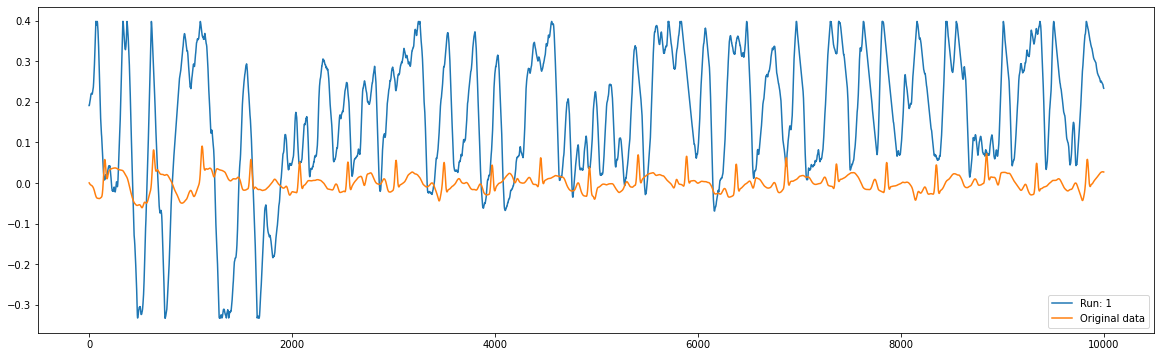

In [8]:
grids = len(data)
time_step = np.linspace(1, len(data), len(data))

predicted_positions = []


for i in range(len(predicted_states)):
    predicted_position = []
    
    for j in range(len(data)):
        predicted_position.append(predicted_states[i][j][0])
    
    predicted_positions.append(predicted_position)
    
    label = "Run: " + str(i+1)
    
    plt.figure(figsize=(20,6))    
    plt.plot(time_step, predicted_position, label = label)
    plt.plot(time_step, data, label = "Original data")
    plt.legend()
    plt.show()
    
#linestyle=":"

In [85]:
import pickle

pickle.dump(predicted_positions, open( "tdlambda_entire3000000.pickle", "wb" ) )

### RMSE Prop

In [9]:
reward_batch = 1

In [10]:
import math

start = 0
end = 0
RMSE_values = []

for pred in predicted_positions:
    start = 0
    end = 0
    RMSE_value = []
    
    for i in range(1, len(data)):
        
        if i % reward_batch == 0:
            start = end
            end = end + reward_batch
            
            true_batch = data[:end]
            predict_batch = pred[:end]
            
            MSE = np.square(np.subtract(true_batch,predict_batch)).mean()
            RMSE = math.sqrt(MSE)
            
            RMSE_value.append(RMSE)
            
    RMSE_values.append(RMSE_value)

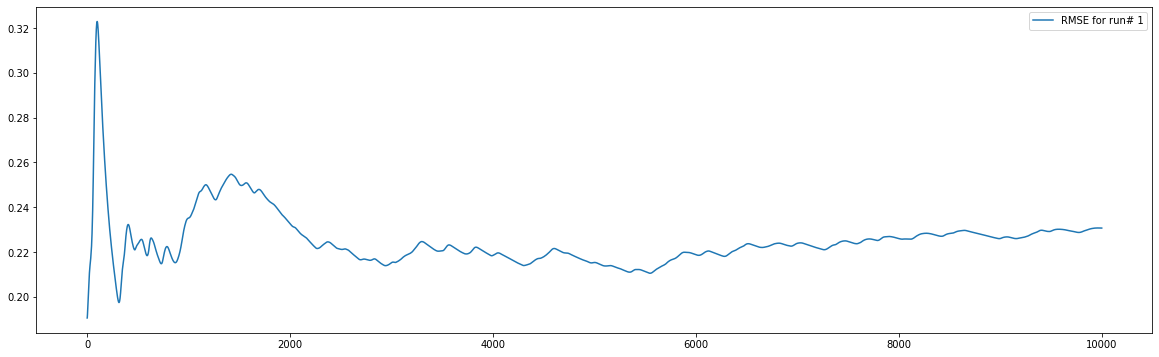

In [11]:
plt.figure(figsize=(20,6))

for i in range(len(RMSE_values)):
    
    grids = len(RMSE_values[i])
    step = np.linspace(1, len(RMSE_values[i]), len(RMSE_values[i]))
    label = "RMSE for run# " + str(i+1)
    
    plt.plot(step, RMSE_values[i], label = label)

plt.legend()
plt.show()

### Cost graph

Text(0.5, 0, 'Cost')

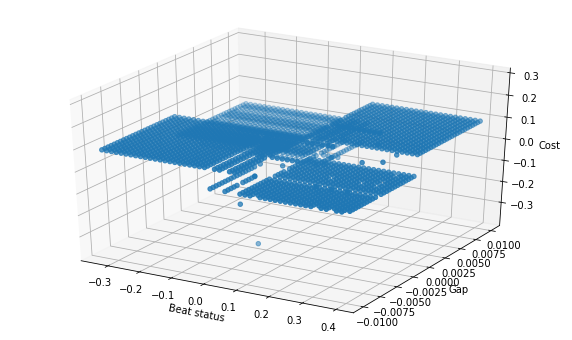

In [35]:
grids = 50

positions = np.linspace(POSITION_BOUND[0][0], POSITION_BOUND[0][1], grids)
vels = np.linspace(GAP_BOUND[0], GAP_BOUND[1], grids)

x = []
y = []
z = []
for p in positions:
    for v in vels:
        x.append(p)
        y.append(v)
        z.append(valueFunc.stepcost([p, v]))

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel("Beat status")
ax.set_ylabel("Gap")
ax.set_zlabel("Cost")